In [17]:
# PHẦN 0: CÀI ĐẶT (chạy 1 lần duy nhất)
!pip install -q transformers datasets torch accelerate lime pyngrok wordcloud scikit-learn xgboost matplotlib seaborn plotly spacy pyvi evaluate
!python -m spacy download en_core_web_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 118.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [18]:
# PHẦN 1: IMPORT & TẢI DATA
import pandas as pd, numpy as np, warnings, nltk, spacy, re
warnings.filterwarnings('ignore')
nltk.download('punkt', quiet=True); nltk.download('stopwords', quiet=True)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from lime.lime_text import LimeTextExplainer
from IPython.display import display, HTML
import evaluate

In [4]:
df_fake_en = pd.read_csv('/content/Fake.csv', engine='python', on_bad_lines='skip')
df_true_en = pd.read_csv('/content/True.csv', engine='python', on_bad_lines='skip')
df_fake_en['label'] = 1
df_true_en['label'] = 0
df_en = pd.concat([df_fake_en[['title', 'label']], df_true_en[['title', 'label']]])
df_en['text'] = df_en['title']
df_en = df_en[['text', 'label']]
df_en

,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
6855,Trump picks longtime friend of Beijing as U.S....,0
6856,Trump chooses pro wrestling magnate Linda McMa...,0
6857,Trump chooses pro wrestling magnate Linda McMa...,0
6858,Kelly confirms he's been asked to be U.S. home...,0


In [2]:
import pandas as pd
# TẢI DATA TIẾNG VIỆT
df_train_vn = pd.read_csv("/content/train.csv")
df_test_vn  = pd.read_csv("/content/test.csv")
df_dev_vn   = pd.read_csv("/content/dev.csv")
df_vn = pd.concat([df_train_vn, df_test_vn, df_dev_vn], ignore_index=True)
df_vn = df_vn[['free_text', 'label_id']].rename(columns={'free_text': 'text', 'label_id': 'label'})  # label: 1 = fake, 0 = real
df_vn

,text,label
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0
...,...,...
33395,Thật sự là đã hi sinh quá nhiều,0
33396,chật chội vậy cơ mà,0
33397,Chống dịch như chống giặc,0
33398,Bao nhiêu ae ra đảo giờ chưa về hôm bữa theo 1...,0


In [8]:
# GỘP TẤT CẢ
df = pd.concat([df_en, df_vn], ignore_index=True).dropna()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"HOÀN TẤT TẢI DATA!")
print(f"Tổng cộng: {len(df):,} mẫu")
print(f" • Tiếng Anh: {len(df_en):,} | Tiếng Việt: {len(df_vn):,}")
print(f" • Tin thật: {len(df[df['label']==0]):,} | Tin giả: {len(df[df['label']==1]):,}\n")

HOÀN TẤT TẢI DATA!
Tổng cộng: 42,493 mẫu
 • Tiếng Anh: 9,095 | Tiếng Việt: 33,400
 • Tin thật: 30,930 | Tin giả: 8,049



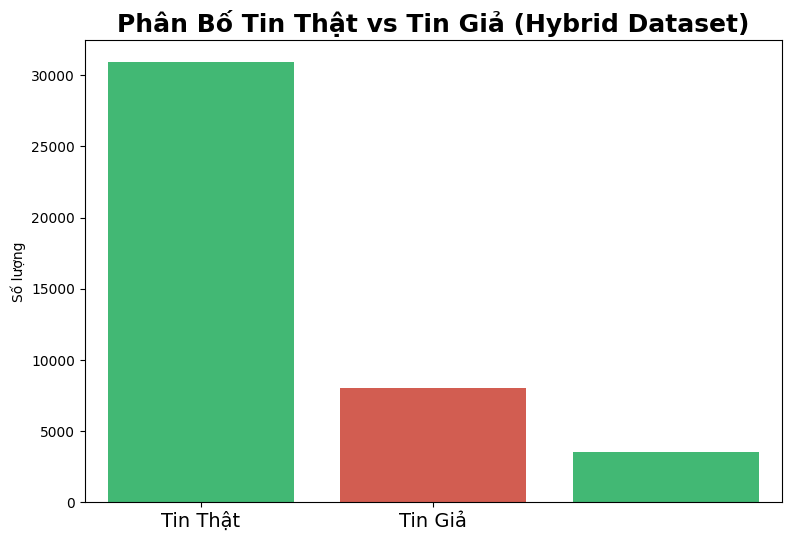

In [9]:
# PHẦN 2: EDA
plt.figure(figsize=(9,6))
sns.countplot(x='label', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Phân Bố Tin Thật vs Tin Giả (Hybrid Dataset)', fontsize=18, fontweight='bold')
plt.xticks([0,1], ['Tin Thật', 'Tin Giả'], fontsize=14)
plt.xlabel(''); plt.ylabel('Số lượng')
plt.show()

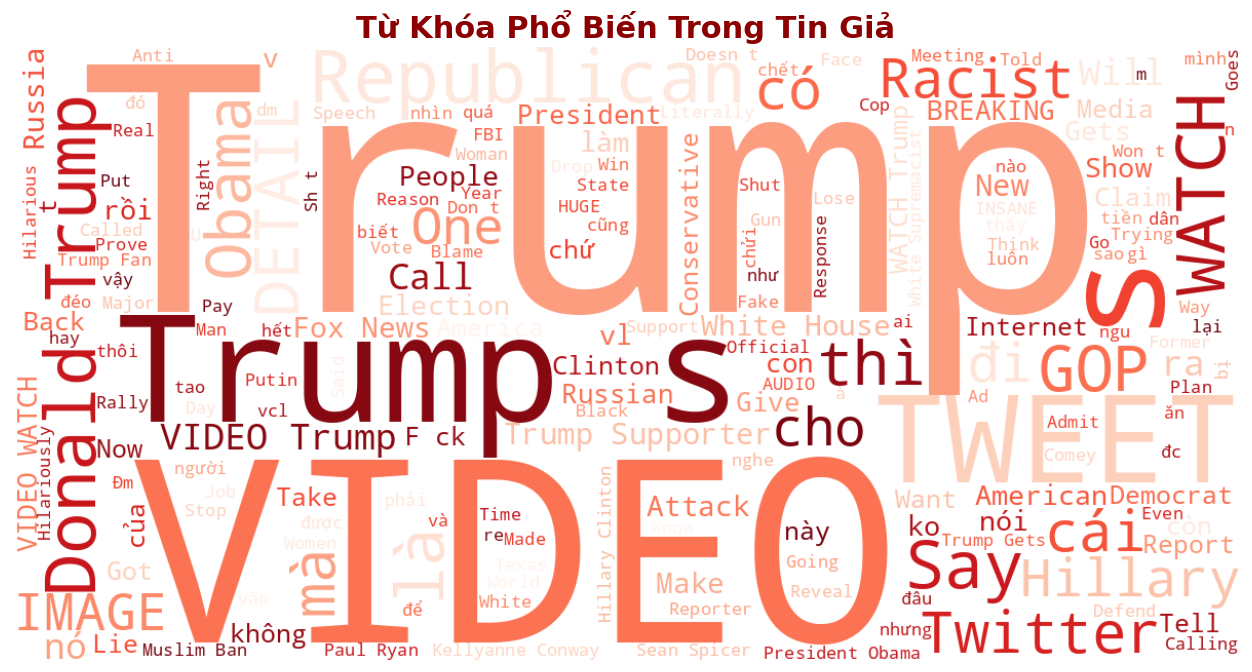

In [10]:
# WordCloud tin giả
fake_words = " ".join(df[df['label']==1]['text'].astype(str))
wc = WordCloud(width=1200, height=600, background_color='white', max_words=200, colormap='Reds').generate(fake_words)
plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation='bilinear')
plt.title('Từ Khóa Phổ Biến Trong Tin Giả', fontsize=22, fontweight='bold', color='darkred')
plt.axis('off'); plt.show()

In [11]:
# Độ dài văn bản
df['length'] = df['text'].str.split().str.len()
fig = px.histogram(df, x='length', color='label', marginal='box', nbins=60,
                   title="Phân Bố Độ Dài Văn Bản Theo Nhãn",
                   labels={'length': 'Số từ'}, color_discrete_map={0:'#2ecc71', 1:'#e74c3c'})
fig.update_layout(barmode='overlay', title_font_size=18)
fig.update_traces(opacity=0.75)
fig.show()

Huấn luyện mô hình cổ điển (TF-IDF + XGBoost)...
Logistic Regression Accuracy: 0.8840

XGBoost + TF-IDF - KẾT QUẢ CHI TIẾT
              precision    recall  f1-score   support

    Tin Thật     0.8782    0.9770    0.9250      6186
     Tin Giả     0.9006    0.6919    0.7826      1610
        Khác     0.7342    0.3969    0.5152       703

    accuracy                         0.8750      8499
   macro avg     0.8377    0.6886    0.7409      8499
weighted avg     0.8706    0.8750    0.8641      8499



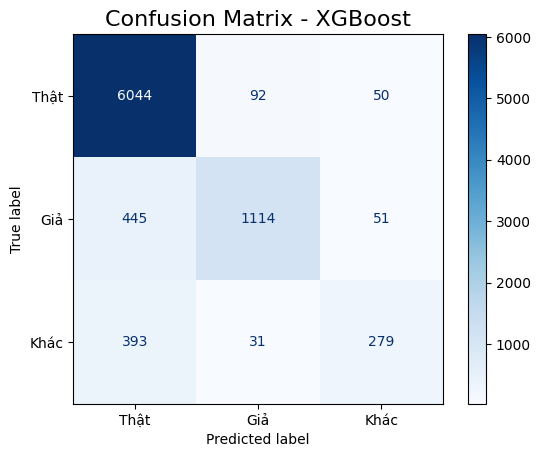

In [22]:
# PHẦN 3: MÔ HÌNH CỔ ĐIỂN
print("Huấn luyện mô hình cổ điển (TF-IDF + XGBoost)...")
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,3))
X = vectorizer.fit_transform(df['text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr.predict(X_test)):.4f}")

# XGBoost
xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42,
                    tree_method='hist') # Changed from 'gpu_hist' to 'hist'
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("\nXGBoost + TF-IDF - KẾT QUẢ CHI TIẾT")
print(classification_report(y_test, y_pred, target_names=['Tin Thật', 'Tin Giả', 'Khác'], labels=[0, 1, 2], digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Thật','Giả', 'Khác'], cmap='Blues')
plt.title('Confusion Matrix - XGBoost', fontsize=16)
plt.show()

In [19]:
# PHẦN 4: PhoBERT (SOTA cho tiếng Việt)
print("\nBắt đầu fine-tune PhoBERT")
df_sample = df.sample(n=12000, random_state=42)  # 12k mẫu để cân bằng tốc độ & chất lượng
train_df, val_df = train_test_split(df_sample, test_size=0.2, random_state=42, stratify=df_sample['label'])

train_ds = Dataset.from_pandas(train_df[['text','label']].rename(columns={'label':'labels'}))
val_ds   = Dataset.from_pandas(val_df[['text','label']].rename(columns={'label':'labels'}))

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
def tokenize_fn(ex):
    return tokenizer(ex["text"], truncation=True, padding=True, max_length=256)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=3)

args = TrainingArguments(
    output_dir="./phobert_fakenews",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=[]
)

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds, tokenizer=tokenizer, compute_metrics=compute_metrics)
trainer.train()
result = trainer.evaluate()
print(f"\nPhoBERT ĐÃ HUẤN LUYỆN XONG! Accuracy: {result['eval_accuracy']:.4f}")


Bắt đầu fine-tune PhoBERT


Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.348500,0.295721,0.905000
2,0.291300,0.332421,0.885833
3,0.209500,0.355510,0.905417
4,0.145200,0.403284,0.906667



PhoBERT ĐÃ HUẤN LUYỆN XONG! Accuracy: 0.9067


In [31]:
# PHẦN 5: EXPLAINABLE AI (LIME + Spacy)
print("\nGiải thích dự đoán bằng LIME + Spacy...")
explainer = LimeTextExplainer(class_names=['Tin Thật', 'Tin Giả'])

def predict_proba_lime(texts):
    vec = vectorizer.transform(texts)
    return xgb.predict_proba(vec)

# Chọn 1 mẫu ngẫu nhiên
idx = np.random.randint(0, len(df))
text_ex = df.iloc[idx]['text']
true_label = "GIẢ" if df.iloc[idx]['label'] == 1 else "THẬT"

print(f"\nVí dụ phân tích: TIN {true_label}")
print(f"Văn bản: {text_ex[:300]}...\n")

exp = explainer.explain_instance(text_ex, predict_proba_lime, num_features=15)
exp.show_in_notebook(text=True)

# Highlight entity bằng Spacy
doc = spacy.load("en_core_web_sm")(text_ex[:500])
html = spacy.displacy.render(doc, style="ent", jupyter=True)
display(HTML("<h3>Nhận diện thực thể (NER) trong văn bản:</h3>"))
display(html)


Giải thích dự đoán bằng LIME + Spacy...

Ví dụ phân tích: TIN GIẢ
Văn bản:  Trump Considering David Petraeus, Who Leaked Highly Classified Info, As Secretary Of Defense...



None